# Wheel Inertia measurements 

For the bicycle Whipple model, we need 2 inertia parameters for each wheel : the one along the pitch axis, and the one around the yaw axis, which is the same as the one in the roll axis. To do so, we place the wheel in a single point of contact and we make it oscillates along each axis. 

### Description of the code
This code was built to identify the period of oscillations from IMU measurements. We chose to measure 3 times each oscillation and compute the mean value of the three. 

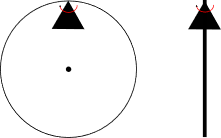
Here is a scheme showing the different oscillations for the wheel.

For each oscillation, we need the following : 
- The distance from the point of contact and the center of gravity (which is considered as the center of the wheel)
- The mass of the wheel

### Libraries

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from filters import * # functions developped for signal filtering
from math import *
from scipy.optimize import curve_fit

### Functions called by the code

In [2]:
def damping_function(t, A,B,ksi,omega,b):
    """
    
    Damping expression on which parameters will be optimized for recognizing the period of oscillations
    
    """
    return A+B*np.exp(-ksi*omega*t) * np.cos(sqrt(1-ksi**2)*omega*t + b)

def identify_period_and_damping(t,signal):
    """
    Identify the period and the damping coefficient of the signal
    
    Args:
        signal (np.ndarray): Temporal signal.
    
    Returns:
        tuple: Tuple with the period and damping coefficient
    """
    # Calcul de la transformée de Fourier du signal
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    
    # Extraction des fréquences les plus importantes
    freqs = freqs[1:len(signal)//2]
    fft = np.abs(fft[1:len(signal)//2])
    
    # Identification de la fréquence dominante
    dominant_freq = freqs[np.argmax(fft)]
    
    # Calcul de la période
    period = 1 / dominant_freq
    
    
    # Calcul des paramètres d'amortissement à partir de la fonction d'amortissement
    ((A,B,ksi,omega,b),_) = curve_fit(damping_function, t, signal,bounds=([0,-10,0,2*3.14/3,-2*3.14],[4,10,1,2*3.14/0.5,2*3.14]))
    
    return A,B,ksi,omega,b

def extract_period(select,list_t_i,axe,draw=0):
    fs=120
    fc=2
    T_fused=[]
    
    for k in range(len(select)):

        data=np.loadtxt(f"{list_name_csv[select[k]]}", delimiter = ',', skiprows = 2, usecols=range(11)).T
        t_i=list_t_i[k]
        ind_t_i=int(t_i*fs)
        gyr_x,gyr_y,gyr_z=data[-3:,:]
        
        
        t_f=data[-3:,:].shape[1]/fs
        t=np.linspace(0,t_f,gyr_x.shape[0])
        
        ax=axe[k]
        if ax=='x':
            gyr=gyr_x
        if ax=='y':
            gyr=gyr_y
        if ax=='z':
            gyr=gyr_z
        
        """plt.figure()
        plt.plot(gyr_x,label = 'Gyr X')
        plt.plot(gyr_y,label = 'Gyr Y')
        plt.plot(gyr_z,label = 'Gyr Z')
        plt.plot(gyr,label='Retenu')
        plt.legend()
        plt.show()"""

        cut_gyr=gyr[ind_t_i:]
        t_cut=np.linspace(0,t_f-t_i,cut_gyr.shape[0])

        
        cut_gyr=butter_lowpass_filter(cut_gyr, fc , fs, order=5)
        cut_gyr=cut_gyr-np.mean(cut_gyr)
        
        peaks, _ = find_peaks(cut_gyr, height=0,distance=60)

        #Les deux premiers points sont retirés car généralement mauvais
        T=np.diff(t[peaks])[2:]
        print(T)
        T_mean=np.mean(T)
        B_max=np.max(np.abs(cut_gyr[peaks]))
        phi=2*3.14*t_cut[peaks][0]/T_mean
        
        # A_mean=np.mean(cut_gyr)
        A_mean=0.1
        
        bounds=([A_mean*0.99,B_max*1,0.001,0.9*2*3.14/T_mean,-phi],[abs(A_mean*1.01),B_max*1.2,0.05,1.1*2*3.14/T_mean,phi])


        p0=[0,B_max*0.9,0.01,2*3.14/T_mean,phi]

        (A,B,ksi,omega,b),_= curve_fit(damping_function, t_cut, cut_gyr,bounds=bounds)
        T_opti=2*3.14/omega
        
        print('Fichier',k,':')
        print('ksi=',ksi)
        print('Omega=',omega,'rad/s')

        T_fused.append(2*3.14/omega)
        
        if draw==1:
            plt.figure()
            gyr_fitted=damping_function(t_cut,A,B,ksi,omega,b)
            plt.plot(t_cut,gyr_fitted,label='optimisée')
            plt.plot(t_cut[peaks], cut_gyr[peaks], "x",label='Pics détectés')
            plt.plot(t_cut,cut_gyr,label='mesure')
            plt.xlabel('Temps (s)')
            plt.ylabel('Vitesse de rotation (°/s)')
            plt.legend()

    if draw==1:
        
        plt.figure()
        
        plt.hist(T_fused)
                
            
    return(T_fused)

def compute_Inertia(m,L,T):
    # Calcul l'inertie au centre de gravité de la pièce à partir 
    # de la période d'oscillation, de la masse et de la distance
    # au centre de gravité
    return(m*9.81*L/(2*3.14/T)**2-m*L**2)

def dI_dm(L,T):
    # Calcul l'incertitude sur l'inertie liée à la masse
    return(9.81*L*T**2/(4*3.14**2)-L**2)

def dI_dT(m,L,T):
    # Calcul l'incertitude sur l'inertie liée à la période
    return(2*T*m*9.81*L/(4*3.14**2))

def dI_dL(m,L,T):
    # Calcul l'incertitude sur l'inertie liée à la distance
    return(m*9.81*T**2/(4*3.14**2)-m*2*L)

Folder on which the csv files are stored

In [3]:
list_name_csv = glob.glob('addbike\\roueAv_tangage\\*.csv')

### Definition of the code variables

# <font color='red'>These variables are the ones you need to modify according to your part</font>

In [4]:
# Select the index of the files for the measure
# (if you only have 3 files, you have nothing to change)
select=[0,1,2] 

# Wheel mass
masses=2.24
# Distance between point of contact and center of the wheel 
distances = 0.188 # m

# Uncertainties estimated for the uncertainty evaluation
u_m=0.02 # mass
u_L=0.002 # distance
u_T=0.02 # period

For each signal, take care of chosing the right axis to recognize the signal. 

In [5]:
axes=['z']*3

Next block will help chosing the right axis for having the maximum signal to noise ratio

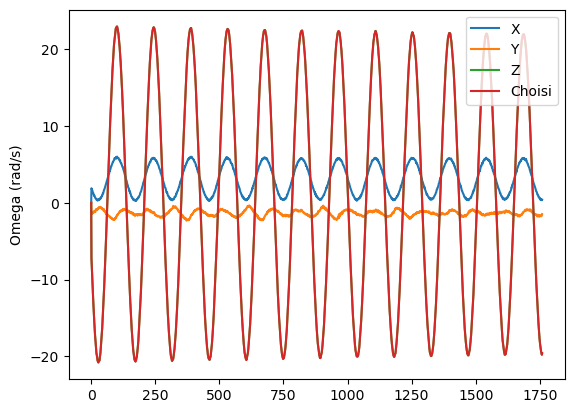

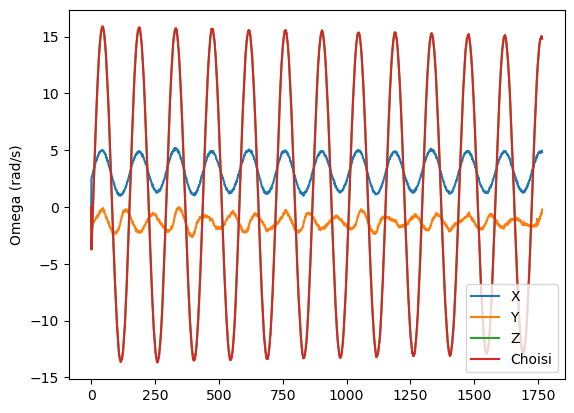

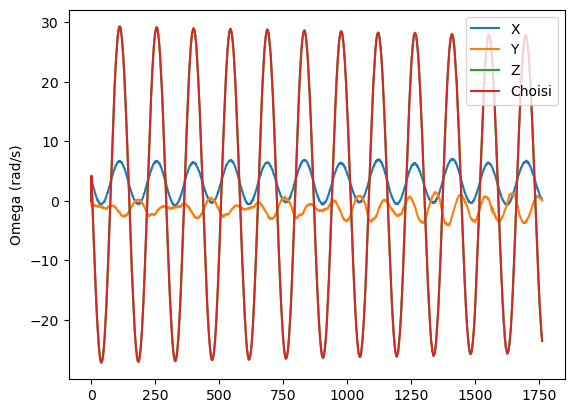

In [6]:
for k in range(len(axes)):
    data=np.loadtxt(f"{list_name_csv[k]}", delimiter = ',', skiprows = 2, usecols=range(11)).T
    gyr_x,gyr_y,gyr_z=data[-3:,:]
    ax=axes[k]
    if ax=='x':
        gyr=gyr_x
    if ax=='y':
        gyr=gyr_y
    if ax=='z':
        gyr=gyr_z
    plt.figure()
    plt.plot(gyr_x,label = 'X')
    plt.plot(gyr_y,label = 'Y')
    plt.plot(gyr_z,label = 'Z')
    plt.plot(gyr,label='Choisi')
    plt.legend()
    plt.ylabel('Omega (rad/s)')

To make sure that we have correct measurements, we crop the signal to keep only the good part of the signal.

In [7]:
times=[3,1,0]

### Inertia calculation with its uncertainties

The inertia will be evaluated by using the following expression, with $\omega$ the pulsation, $L$ the distance and $m$ the mass of the wheel. 
$$I = \frac{m g L} {\omega^2} - m L^2$$

In [8]:
T_0=extract_period(select,times,axes)

T_mean=np.mean(T_0)
T_std=np.std(T_0)

I=compute_Inertia(masses,distances,np.array(T_0))

I_mean=np.mean(I)

[1.20068221 1.20902028 1.20068221 1.20068221 1.20902028 1.20068221
 1.20068221]
Fichier 0 :
ksi= 0.0010000000000002104
Omega= 5.219107828631807 rad/s
[1.19234145 1.19234145 1.19234145 1.2006795  1.19234145 1.19234145
 1.19234145 1.19234145]
Fichier 1 :
ksi= 0.0018086800426558498
Omega= 5.267239007257083 rad/s
[1.20068104 1.20068104 1.20068104 1.20901911 1.20068104 1.20068104
 1.20068104 1.20901911 1.20068104]
Fichier 2 :
ksi= 0.0010000000000000002
Omega= 5.217777400315192 rad/s


In [9]:
u_m=0.02
u_L=0.002
u_T=T_std

u_I=np.sqrt(dI_dm(distances,T_mean)**2*u_m**2+dI_dT(masses,distances,T_mean)**2*u_T**2+dI_dL(masses,distances,T_mean)**2*u_T**2)

print("Uncertainties evaluated by an analytical method :")
print('Inertia :','I=',round(I_mean,3),'kg.m²',"+/-",round(u_I,4))
print('-----------------------------------------')

Uncertainties evaluated by an analytical method :
Inertia : I= 0.072 kg.m² +/- 0.0015
-----------------------------------------
